# Training Consistency Models on FashionMNIST using miniai

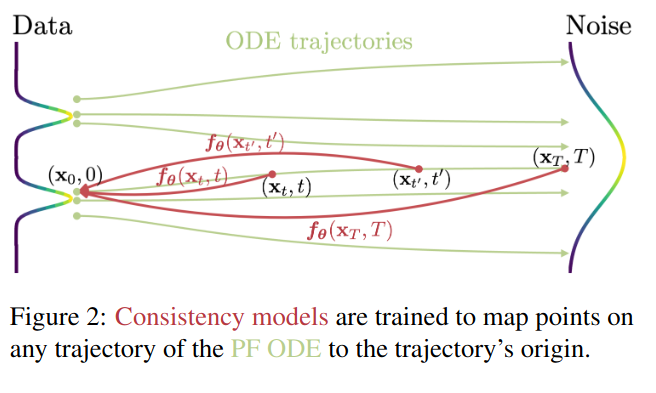

## Imports

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
from miniai.imports import *
from miniai.diffusion import *
from diffusers import UNet2DModel
from fastprogress import progress_bar
from glob import glob
from copy import deepcopy

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

Use HuggingFace Datasets to load the Fashion MNIST dataset.

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

Found cached dataset fashion_mnist (/home/tmabraham/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

Noisification based on Karras et al. (https://arxiv.org/pdf/2206.00364.pdf)

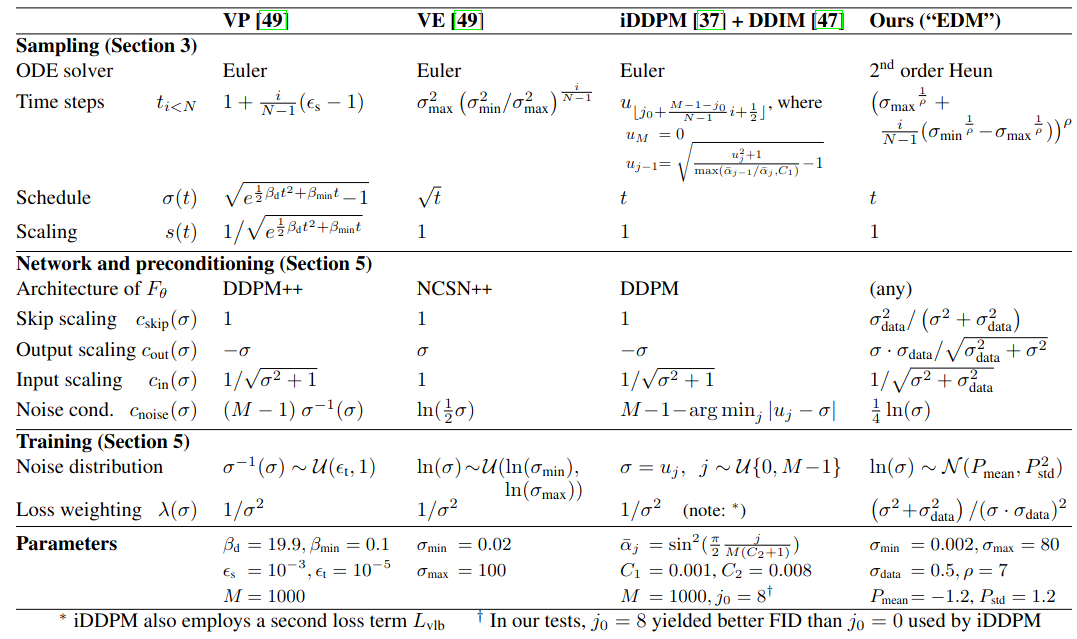

notes on symbols used
- sig = sigma = σ
- eps = epsilon = ϵ
- c_* = constant

In [ ]:
# Page 3, Network and preconditioning (Section 5), column Ours ("EDM")
sig_data=0.5
# Calculate scaling factors c_skip, c_out and c_in
def scalings(sig, eps):
    c_skip = sig_data ** 2 / ((sig - eps) ** 2 + sig_data ** 2)
    c_out = (sig - eps) * sig_data / (sig ** 2 + sig_data ** 2).sqrt()
    c_in = 1 / ((sig - eps) ** 2 + sig_data ** 2).sqrt()
    return c_skip, c_out, c_in

In [ ]:
# Page 3, Sampling (Section 3), column Ours ("EDM")
def sigmas_karras(n, sigma_min=0.002, sigma_max=80., rho=7.):
    # rising from 0 to 1 over n steps
    ramp = torch.linspace(0, 1, n)
    # this is "Time steps" formula
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas.cuda()

Create DataLoaders:

In [ ]:
def collate_consistency(b): return default_collate(b)[xl]
def dl_consistency(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_consistency, num_workers=8)

In [ ]:
@inplace
# this is a common way to normalize image data in pytorch
# .pad() is adding 2 rows / columns of zeroes to top, right, bottom, left
# then *2-1 is shifting range of pixel values from -1 to 1
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

# as above dsd is the imported dataset
tds = dsd.with_transform(transformi)
# splitting dataset into different training and test sets
dls = DataLoaders(dl_consistency(tds['train']), dl_consistency(tds['test']))

## Consistency model

Model parameterization as described in the paper (https://arxiv.org/pdf/2303.01469.pdf - "Appendix C: Additional Experimental Details"):

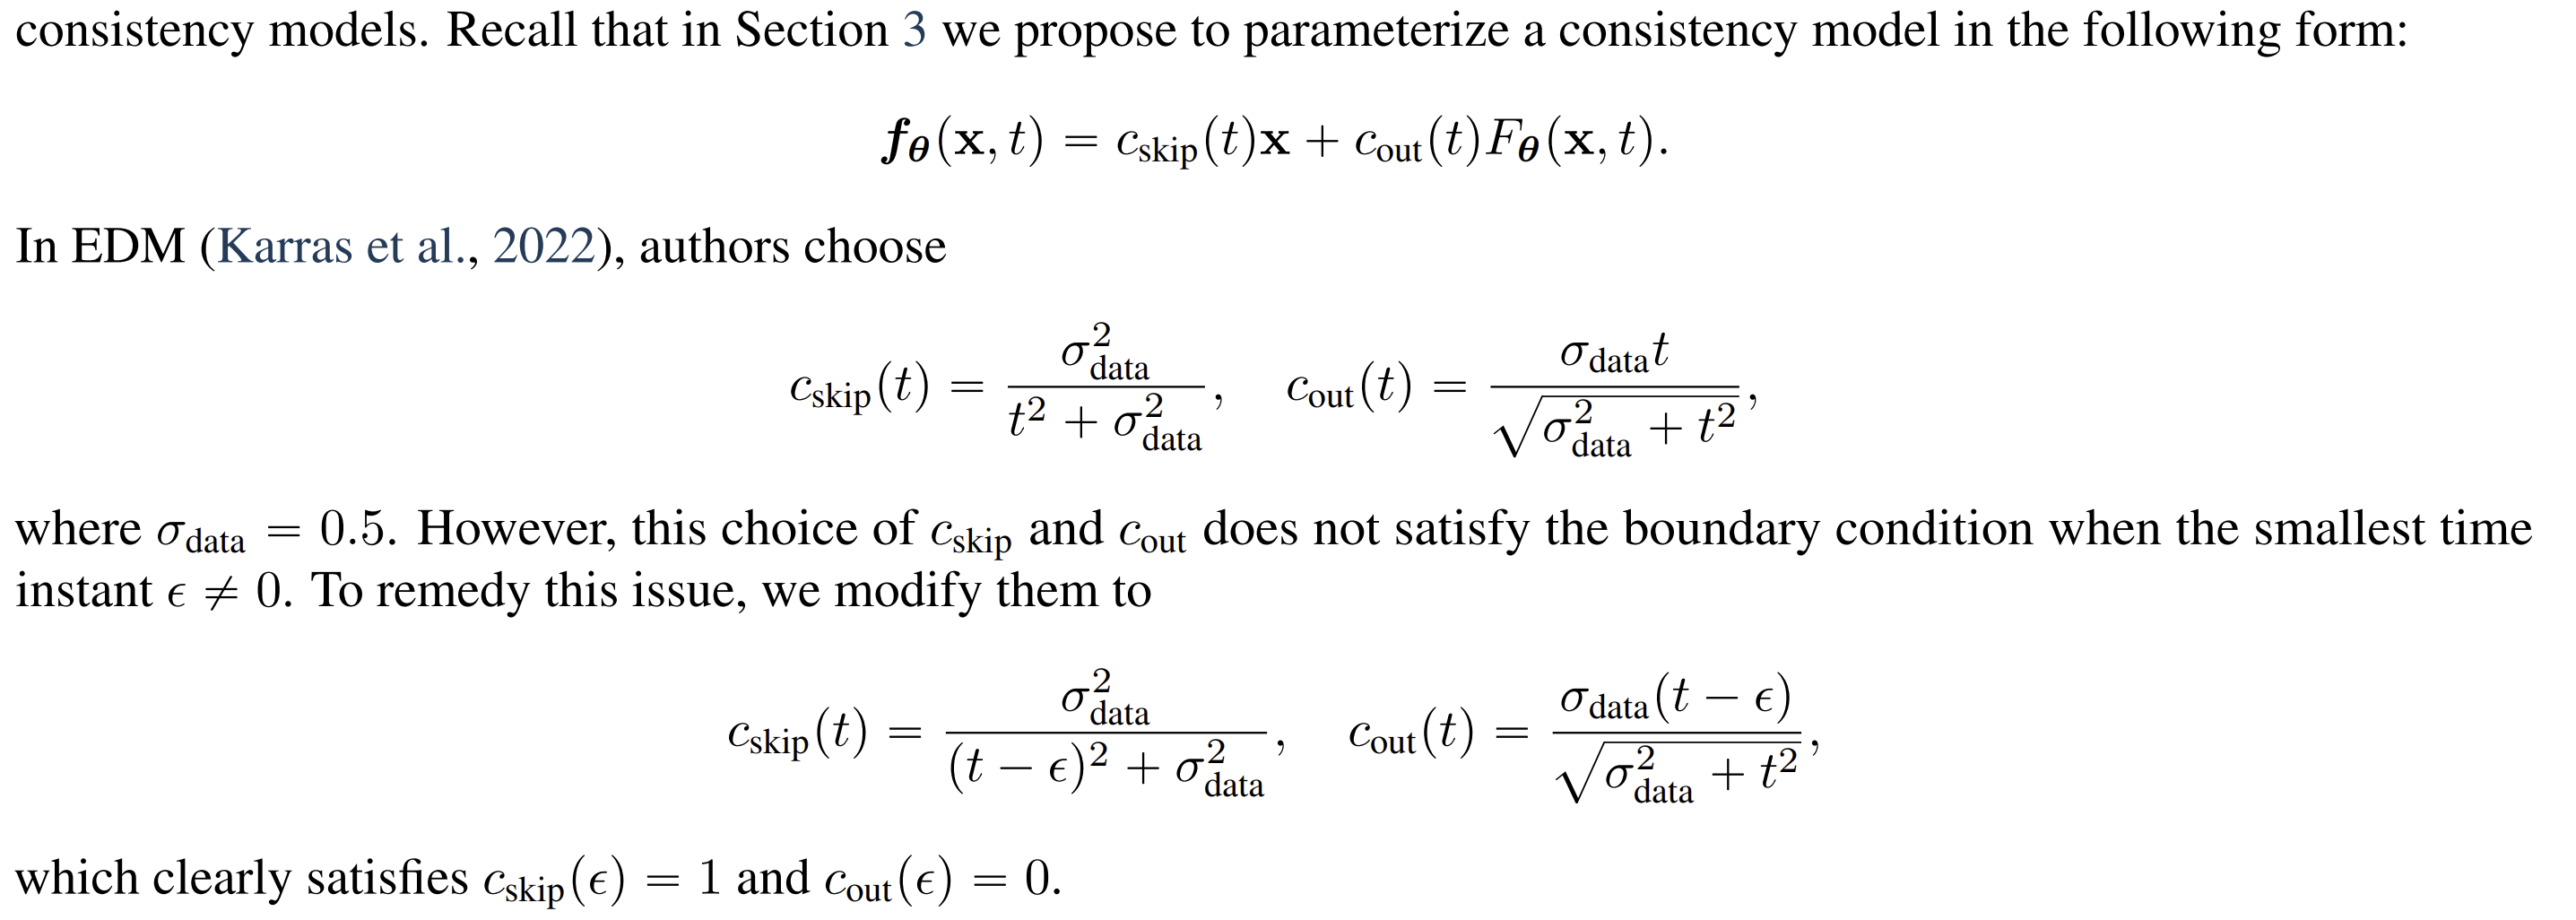

In [ ]:
# ConsistencyUNet implements the above function "Appendix C: Additional Experimental Details"
class ConsistencyUNet(nn.Module):
    def __init__(self, eps, model):
        super().__init__()
        self.eps = eps
        self.F = model 
        
    def forward(self, inp):
        x, sig = inp
        # sig is the noise i think here
        # .reshape(-1,1,1,1) output will have shape (n, 1, 1, 1) where n is number of elements
        c_skip, c_out, c_in = scalings(sig.reshape(-1,1,1,1), self.eps)
        # .squeeze() removes dimensions of size 1, for instance shape (32, 1, 1, 16) becomes (32, 16)
        return c_skip * x + c_out * self.F((x, sig.squeeze()))

In [ ]:
# UNet is type of neural network architecture used for images
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

miniai Callback for Consistency Model training. 

Before training, create EMA model.

During each batch of training, calculate maximum timestep based on the adaptive N schedule. Our new batch is now $((\mathbf{x}_n,\sigma_n),(\mathbf{x}_{n+1},\sigma_{n+1}))$. The second tuple is passed into the EMA model while the first is passed into the regular model and the loss is the MSE between both of these outputs. 

Finally, the EMA model is updated.

**Notes:**

Whats an EMA model?

ChatGPT: EMA stands for Exponential Moving Average. It's a time-series forecasting model that assigns more weight to recent data points and less weight to older ones using a smoothing factor. It's useful for capturing short-term variations while still considering long-term trends.

https://old.reddit.com/r/StableDiffusion/comments/x5am4v/ema_model_vs_non_ema_differences/
If you set EMA to 'true' when training it makes a smaller pool to pull from, based on recent history rather than all history (all history still exists), meaning the model will be pretty specific based on what you are attempting to train, i.e; you don't want your cars to suddenly develop wings or faces. That's why it's used for "fine tuning". Good for making custom models (aka filters).

https://timm.fast.ai/training_modelEMA
When training a model, it is often beneficial to maintain moving averages of the trained parameters. Evaluations that use averaged parameters sometimes produce significantly better results than the final trained values. 

A comment about Algorithm 2 Consistency Distillation (CD) & Algorithm 3 Consistency Training (CT) in https://arxiv.org/pdf/2303.01469.pdf

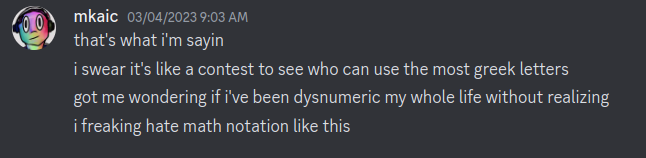

This is what the self.N value is doing with starting value N=150

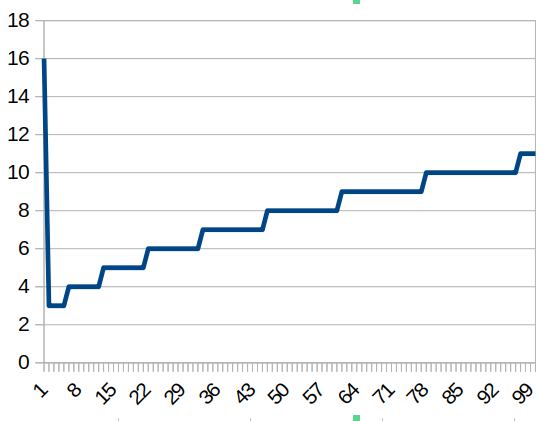

This is what sigmas_karras is doing with N=10

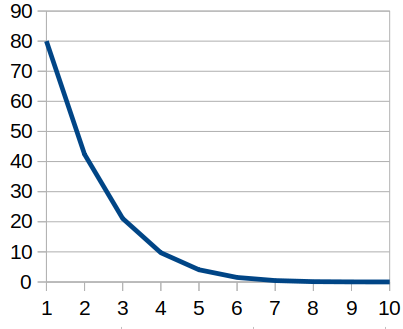

In [ ]:
# https://arxiv.org/pdf/2303.01469.pdf - Algorithm 3 Consistency Training (CT)
class ConsistencyCB(TrainCB):
    def __init__(self, N=150):
        super().__init__()
        self.N=N
    
    # called before training loop starts
    def before_fit(self, learn): 
        self.ema_model = deepcopy(learn.model)
        self.ema_model.load_state_dict(learn.model.state_dict())
        
    # called before each batch is processed (think batch size)
    def before_batch(self, learn):
        # this value slowly increases over the epochs - Progressive Resizing (PR) training technique?
        # Is this link relevant? https://docs.mosaicml.com/en/latest/method_cards/progressive_resizing.html
        self.N = math.ceil(math.sqrt((learn.epoch+1 * (self.N**2 - 4) / learn.n_epochs) + 4) - 1) + 1
        # .flip(dims=(-1,)) flips along its last dimension eg [1,2,3,4] -> [4,3,2,1]
        # descending to ascending ramp
        noise_sched = sigmas_karras(self.N).flip(dims=(-1,))
        x0 = learn.batch # original images, x_0
        device = x0.device
        #  0 =< t < self.N-1, obtain a random integer tensor of length len(x0)
        t = torch.randint(self.N-1, [len(x0)])
        # adds 1 to every item in t
        t_1 = t+1
        sig_n = noise_sched[t].reshape(-1,1,1,1).to(device)
        sig_n_1 = noise_sched[t_1].reshape(-1,1,1,1).to(device)
        # creates gaussian noise with same shape as x0
        z = torch.randn_like(x0, device=device)
        noised_input_n = x0 + sig_n*z
        noised_input_n_1 = x0 + sig_n_1*z
        learn.batch = (noised_input_n, sig_n), (noised_input_n_1, sig_n_1)

    # called to make predictions on input data
    def predict(self, learn): 
        # n_inp is the number of inputs the model expects to receive
        with torch.no_grad(): learn.preds = self.ema_model(*learn.batch[:self.n_inp]) 

    # called to calculated the loss between predicted and actual values  
    def get_loss(self, learn): 
        learn.loss = learn.loss_func(learn.preds, learn.model(*learn.batch[self.n_inp:]))

    # called after each optimization step, post processing
    def after_step(self, learn):
        with torch.no_grad():
            mu = math.exp(2 * math.log(0.95) / self.N)
            # update \theta_{-}
            for p, ema_p in zip(learn.model.parameters(), self.ema_model.parameters()):
                ema_p.mul_(mu).add_(p, alpha=1 - mu)

Setup and start training:

In [ ]:
# lr is the learning rate
lr = 3e-5
# complete passes through the training set
epochs = 100
# optimisation function
opt_func = optim.AdamW
# callbacks to run
# DeviceCB, ProgressCB, MetricsCB are all imported
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), ConsistencyCB()]
# setup the neural network
unet = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)
model = ConsistencyUNet(0.002, unet) 
# setup the learner with model, dataset, mean squared error loss, learning rate, callbacks, optimisation function
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.269,0,train
0.218,0,eval
0.205,1,train
0.201,1,eval
0.201,2,train
0.198,2,eval
0.162,3,train
0.133,3,eval
0.133,4,train
0.133,4,eval


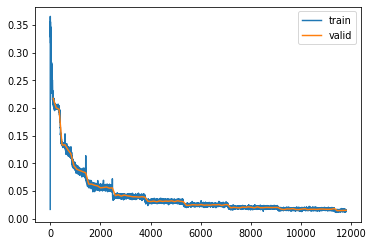

In [ ]:
# start training
learn.fit(epochs)

## Sampling

In [ ]:
import gc
gc.collect()

8678

In [ ]:
torch.cuda.empty_cache()

Sampling with one-step is extremely simple 😉

In [ ]:
def one_step_sample(model,sz):
    lastN = learn.cbs[-1].N
    # .flip(dims=(-1,))[-1] is the same is [0] i think
    sig = sigmas_karras(lastN).flip(dims=(-1,))[-1] # get the max variance
    x = torch.randn(sz).cuda() * sig # create noise
    # sig[None] is equivalent to sig.unsqueeze(0)
    sig = sig[None] * torch.ones((len(x),1)).cuda().reshape(-1,1,1,1) # reshape it appropriately
    return model((x,sig)) # simply return model output

In [ ]:
sz = (512, 1, 32, 32)

In [ ]:
s = one_step_sample(learn.model,sz)

You can see our samples are not perfect, but impressive for a single step!

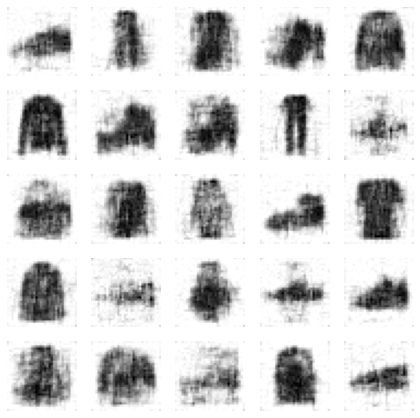

In [ ]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

We can refine with the multi-step algorithm too. Here I just choose some seemingly appropriate timesteps, the original paper actually uses a greedy algorithm to optimize the timepoints used to get the best FID (although details on this seems minimal IMO).

In [ ]:
x=s
for sig in reversed([5.0, 10.0, 20.0, 40.0]):
    print(sig)
    z = torch.randn_like(x)
    # adds noise
    x = x + math.sqrt((sig)**2 - learn.model.eps**2) * torch.randn(sz).cuda()
    # this is just broadcasting sig to shape (len(x), 1) then reshaping eg result is [ [[[5.0]]], [[[5.0]]], ... etc]
    sig = tensor(sig)[None].cuda() * torch.ones((len(x),1)).cuda().reshape(-1,1,1,1)
    x = learn.model((x, sig))
    gc.collect()
    torch.cuda.empty_cache()
s=x

40.0
20.0
10.0
5.0


Outputs still a little noisy, but quite good for 5 steps!

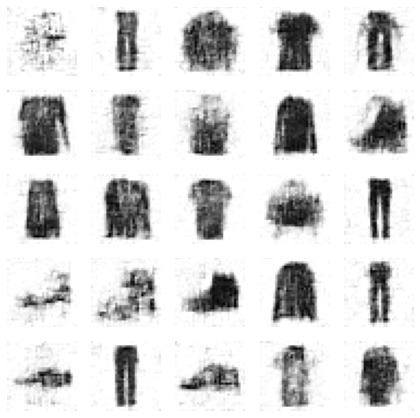

In [ ]:
show_images(s[:25].clamp(-1,1), imsize=1.5)